In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%%capture
%cd drive/MyDrive/genrecog/
%pip install speechbrain
%pip install torchlibrosa

In [3]:
from genrecog.preprocess.preprocessor import Preprocessor
from genrecog.nnet.RNN import VanillaRNN
from genrecog.tools.trainer import RNNFbankTrainer
import torch
from torch.utils.data import TensorDataset, DataLoader 
import datetime

torch.manual_seed(0)

In [4]:
# Load dataset

train_preprcessor = Preprocessor('dataset/npz_files/train.npz')
test_preprcessor = Preprocessor('dataset/npz_files/test.npz')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
X, y = train_preprcessor.as_shuffled_torch()
X_test, y_test = test_preprcessor.as_shuffled_torch()

dataset = TensorDataset(X.to(device), y.to(device))
validation_dataset, train_dataset = torch.utils.data.random_split(dataset, (400, 3200))
test_dataset = TensorDataset(X_test.to(device), y_test.to(device))

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=400)
validation_dataloader = DataLoader(validation_dataset, shuffle=True, batch_size=400)
test_dataloader = DataLoader(test_dataset, shuffle=True, batch_size=400)

In [6]:
hidden_size = 128
num_layers = 5
input_size = 40
output_dim = 10
time_sequence = 702
lr = 0.001
model = VanillaRNN(
    input_size=input_size, 
    time_sequence=time_sequence,
    hidden_size=hidden_size, 
    num_layers=num_layers, 
    output_dim=output_dim,
    use_mean=False
    ).to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
model

VanillaRNN(
  (batch_norm_input): BatchNorm1d(702, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rnn): RNN(40, 128, num_layers=5, batch_first=True)
  (batch_norm_hidden): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=128, out_features=10, bias=True)
)

In [7]:
trainer = RNNFbankTrainer(
    model=model, 
    optimizer=optimizer, 
    loss=loss, 
    train_dataloader=train_dataloader, 
    validation_dataloader=validation_dataloader, 
    num_epochs=100)
trainer.train()

============================== EPOCH 1 =================================
Training accuracy 29.97
Training loss 2.0012
Validation accuracy 19.75
Validation loss 2.2944
============================== EPOCH 2 =================================
Training accuracy 37.59
Training loss 1.7807
Validation accuracy 21.00
Validation loss 2.1692
============================== EPOCH 3 =================================
Training accuracy 40.25
Training loss 1.7022
Validation accuracy 32.00
Validation loss 1.9146
============================== EPOCH 4 =================================
Training accuracy 41.50
Training loss 1.6464
Validation accuracy 33.50
Validation loss 1.8739
============================== EPOCH 5 =================================
Training accuracy 43.06
Training loss 1.6134
Validation accuracy 38.00
Validation loss 1.7625
============================== EPOCH 6 =================================
Training accuracy 43.16
Training loss 1.5922
Validation accuracy 27.25
Validation loss 1.928

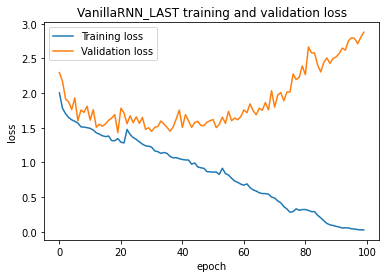

In [8]:
trainer.plot_loss("VanillaRNN_LAST training and validation loss")

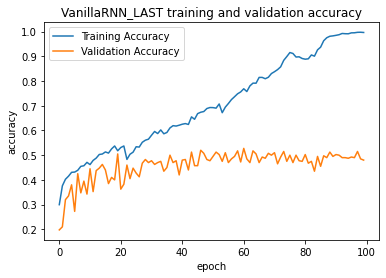

In [9]:
trainer.plot_accuracies("VanillaRNN_LAST training and validation accuracy")

In [10]:
trainer.eval(test_dataloader)

(tensor([6, 8, 2, 4, 1, 1, 5, 8, 8, 4, 5, 0, 8, 5, 9, 9, 0, 7, 3, 8, 9, 1, 4, 8,
         3, 7, 2, 9, 5, 2, 4, 1, 1, 9, 2, 5, 5, 5, 7, 1, 1, 4, 5, 5, 6, 0, 5, 9,
         4, 3, 3, 4, 2, 4, 5, 7, 6, 9, 7, 6, 8, 0, 8, 3, 8, 4, 3, 2, 2, 7, 5, 5,
         9, 8, 1, 6, 3, 6, 5, 7, 1, 8, 1, 9, 4, 3, 5, 0, 7, 9, 7, 6, 2, 8, 5, 0,
         1, 9, 6, 4, 4, 6, 6, 0, 7, 0, 4, 2, 1, 7, 1, 9, 5, 1, 4, 2, 7, 3, 0, 5,
         3, 5, 6, 2, 7, 1, 1, 9, 7, 1, 1, 3, 6, 3, 5, 5, 1, 5, 4, 9, 3, 4, 2, 4,
         7, 9, 8, 4, 6, 9, 0, 4, 7, 6, 9, 6, 8, 6, 7, 3, 5, 7, 7, 7, 1, 8, 6, 7,
         1, 6, 4, 3, 9, 0, 1, 3, 5, 6, 6, 2, 8, 5, 6, 5, 9, 9, 9, 1, 1, 7, 0, 8,
         5, 2, 8, 6, 5, 9, 4, 5, 3, 2, 5, 0, 6, 0, 3, 6, 9, 2, 7, 1, 7, 5, 3, 4,
         9, 7, 9, 7, 2, 2, 5, 7, 0, 8, 9, 8, 4, 8, 4, 4, 8, 8, 0, 6, 0, 8, 7, 8,
         7, 4, 6, 2, 2, 7, 0, 8, 0, 7, 2, 6, 7, 9, 6, 1, 5, 1, 3, 9, 4, 7, 1, 8,
         7, 0, 2, 4, 8, 5, 3, 1, 4, 6, 5, 1, 4, 3, 0, 3, 6, 5, 7, 3, 6, 4, 1, 7,
         3, 8, 3, 0, 8, 5, 8

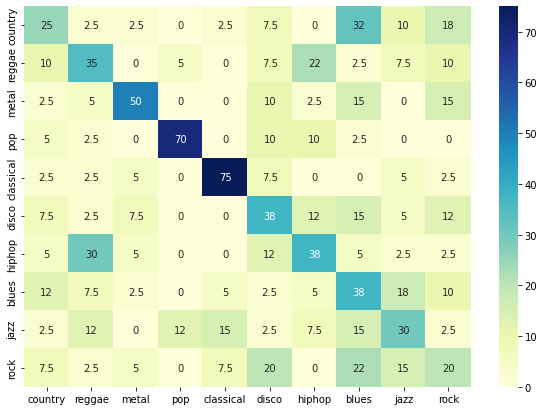

In [11]:
trainer.plot_confusion_matrix(test_dataloader)

In [12]:
trainer.classification_report(test_dataloader)

              precision    recall  f1-score   support

     country       0.31      0.25      0.28        40
      reggae       0.34      0.35      0.35        40
       metal       0.65      0.50      0.56        40
         pop       0.80      0.70      0.75        40
   classical       0.71      0.75      0.73        40
       disco       0.32      0.38      0.34        40
      hiphop       0.38      0.38      0.38        40
       blues       0.25      0.38      0.30        40
        jazz       0.32      0.30      0.31        40
        rock       0.22      0.20      0.21        40

    accuracy                           0.42       400
   macro avg       0.43      0.42      0.42       400
weighted avg       0.43      0.42      0.42       400



In [28]:
hidden_size = 128
num_layers = 5
input_size = 40
output_dim = 10
time_sequence = 702
lr = 0.001
model_2 = VanillaRNN(
    input_size=input_size, 
    time_sequence=time_sequence,
    hidden_size=hidden_size, 
    num_layers=num_layers, 
    output_dim=output_dim,
    use_mean=False
    ).to(device)
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2.parameters(), lr=lr)
model_2

VanillaRNN(
  (batch_norm_input): BatchNorm1d(702, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (rnn): RNN(40, 128, num_layers=5, batch_first=True)
  (batch_norm_hidden): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (linear): Linear(in_features=128, out_features=10, bias=True)
)

In [29]:
trainer_2 = RNNFbankTrainer(
    model=model_2, 
    optimizer=optimizer, 
    loss=loss, 
    train_dataloader=train_dataloader, 
    validation_dataloader=validation_dataloader, 
    num_epochs=20)
trainer_2.train()

============================== EPOCH 1 =================================
Training accuracy 29.84
Training loss 1.9976
Validation accuracy 19.00
Validation loss 2.2797
============================== EPOCH 2 =================================
Training accuracy 37.19
Training loss 1.7974
Validation accuracy 20.25
Validation loss 2.1473
============================== EPOCH 3 =================================
Training accuracy 39.41
Training loss 1.7320
Validation accuracy 36.75
Validation loss 1.8216
============================== EPOCH 4 =================================
Training accuracy 41.28
Training loss 1.6722
Validation accuracy 40.50
Validation loss 1.7135
============================== EPOCH 5 =================================
Training accuracy 41.12
Training loss 1.6402
Validation accuracy 36.00
Validation loss 1.7522
============================== EPOCH 6 =================================
Training accuracy 43.50
Training loss 1.6097
Validation accuracy 28.25
Validation loss 1.883

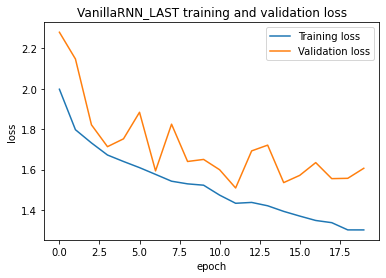

In [30]:
trainer_2.plot_loss("VanillaRNN_LAST training and validation loss")

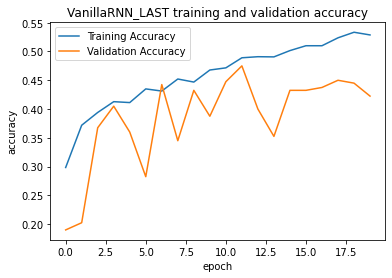

In [31]:
trainer_2.plot_accuracies("VanillaRNN_LAST training and validation accuracy")

In [32]:
trainer_2.eval(test_dataloader)

(tensor([1, 0, 1, 5, 2, 1, 2, 8, 2, 7, 2, 2, 5, 2, 0, 5, 8, 4, 5, 4, 0, 2, 5, 2,
         8, 5, 7, 7, 1, 7, 5, 8, 9, 4, 8, 8, 9, 2, 2, 6, 5, 1, 0, 4, 1, 5, 5, 8,
         8, 2, 2, 7, 8, 5, 2, 6, 5, 5, 8, 6, 0, 5, 5, 1, 5, 7, 1, 5, 1, 2, 7, 7,
         5, 8, 5, 1, 9, 2, 6, 6, 5, 4, 4, 4, 5, 7, 7, 8, 5, 5, 2, 0, 4, 5, 1, 7,
         2, 5, 9, 3, 5, 2, 0, 7, 8, 8, 9, 8, 8, 5, 4, 7, 8, 7, 1, 9, 0, 1, 2, 5,
         2, 9, 7, 3, 3, 0, 1, 9, 9, 0, 5, 7, 1, 6, 5, 5, 4, 7, 2, 7, 1, 2, 8, 0,
         2, 4, 3, 9, 4, 8, 0, 0, 8, 8, 5, 2, 2, 7, 8, 7, 8, 5, 0, 8, 4, 8, 7, 4,
         8, 0, 4, 0, 5, 7, 8, 5, 5, 8, 0, 8, 2, 5, 9, 8, 4, 4, 5, 4, 8, 8, 6, 7,
         9, 2, 8, 3, 8, 8, 7, 8, 7, 4, 1, 5, 4, 2, 2, 6, 5, 4, 8, 9, 2, 1, 1, 1,
         4, 0, 0, 0, 6, 7, 8, 7, 3, 8, 0, 9, 5, 2, 6, 5, 2, 7, 1, 5, 7, 0, 8, 6,
         1, 1, 8, 1, 0, 0, 8, 5, 8, 3, 0, 1, 3, 9, 5, 2, 9, 8, 0, 9, 8, 2, 4, 2,
         8, 7, 5, 3, 2, 5, 9, 9, 5, 1, 2, 8, 3, 0, 1, 9, 7, 9, 9, 5, 4, 9, 2, 4,
         8, 1, 4, 6, 2, 9, 0

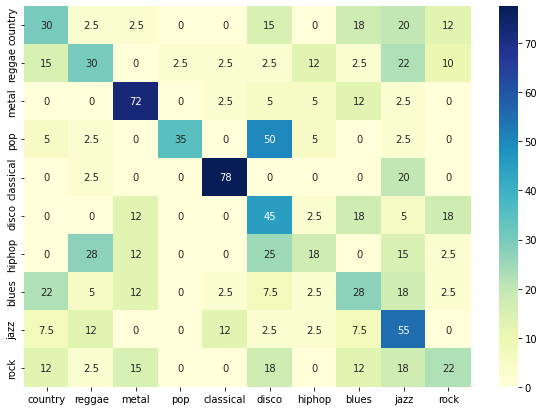

In [33]:
trainer_2.plot_confusion_matrix(test_dataloader)

In [34]:
trainer_2.classification_report(test_dataloader)

              precision    recall  f1-score   support

     country       0.32      0.30      0.31        40
      reggae       0.35      0.30      0.32        40
       metal       0.57      0.72      0.64        40
         pop       0.93      0.35      0.51        40
   classical       0.79      0.78      0.78        40
       disco       0.26      0.45      0.33        40
      hiphop       0.37      0.17      0.24        40
       blues       0.28      0.28      0.28        40
        jazz       0.31      0.55      0.40        40
        rock       0.33      0.23      0.27        40

    accuracy                           0.41       400
   macro avg       0.45      0.41      0.41       400
weighted avg       0.45      0.41      0.41       400

